In [1]:
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [6]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

data_dir = "./final_model/data"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 3852 files belonging to 4 classes.
Using 3082 files for training.
Found 3852 files belonging to 4 classes.
Using 770 files for validation.


In [7]:
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
2.  Corn_(maize)___Common_rust_
3.  Corn_(maize)___Northern_Leaf_Blight
4.  Corn_(maize)___healthy


In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
# add more augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
]

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input 

base_model = tf.keras.applications.EfficientNetB0(
                                include_top=False,
                                weights="imagenet",
                                input_shape=IMG_SHAPE,
                            )

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [11]:
base_model.trainable = True

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [13]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [14]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
______________________________________________

In [20]:
initial_epochs = 4

In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/4
  2/105 [..............................] - ETA: 49:24 - loss: 1.3261 - accuracy: 0.3594 - precision: 0.8000 - recall: 0.0625  

KeyboardInterrupt: 

In [ ]:
history.history

{'loss': [0.28743675351142883,
  0.10780327767133713,
  0.07408515363931656,
  0.07528646290302277],
 'accuracy': [0.9074591398239136,
  0.9650837779045105,
  0.9756879806518555,
  0.9758431911468506],
 'precision': [0.9357403516769409,
  0.968234121799469,
  0.9778124094009399,
  0.97746741771698],
 'recall': [0.8888371586799622,
  0.9617732167243958,
  0.9734119772911072,
  0.973877489566803],
 'val_loss': [0.13119971752166748,
  0.05945736542344093,
  0.05591388791799545,
  0.054218925535678864],
 'val_accuracy': [0.9589359760284424,
  0.9816632270812988,
  0.9808884263038635,
  0.9816632270812988],
 'val_precision': [0.9637454152107239,
  0.9844276905059814,
  0.981371283531189,
  0.9824107885360718],
 'val_recall': [0.9542871713638306,
  0.9795970916748047,
  0.9795970916748047,
  0.9808884263038635]}

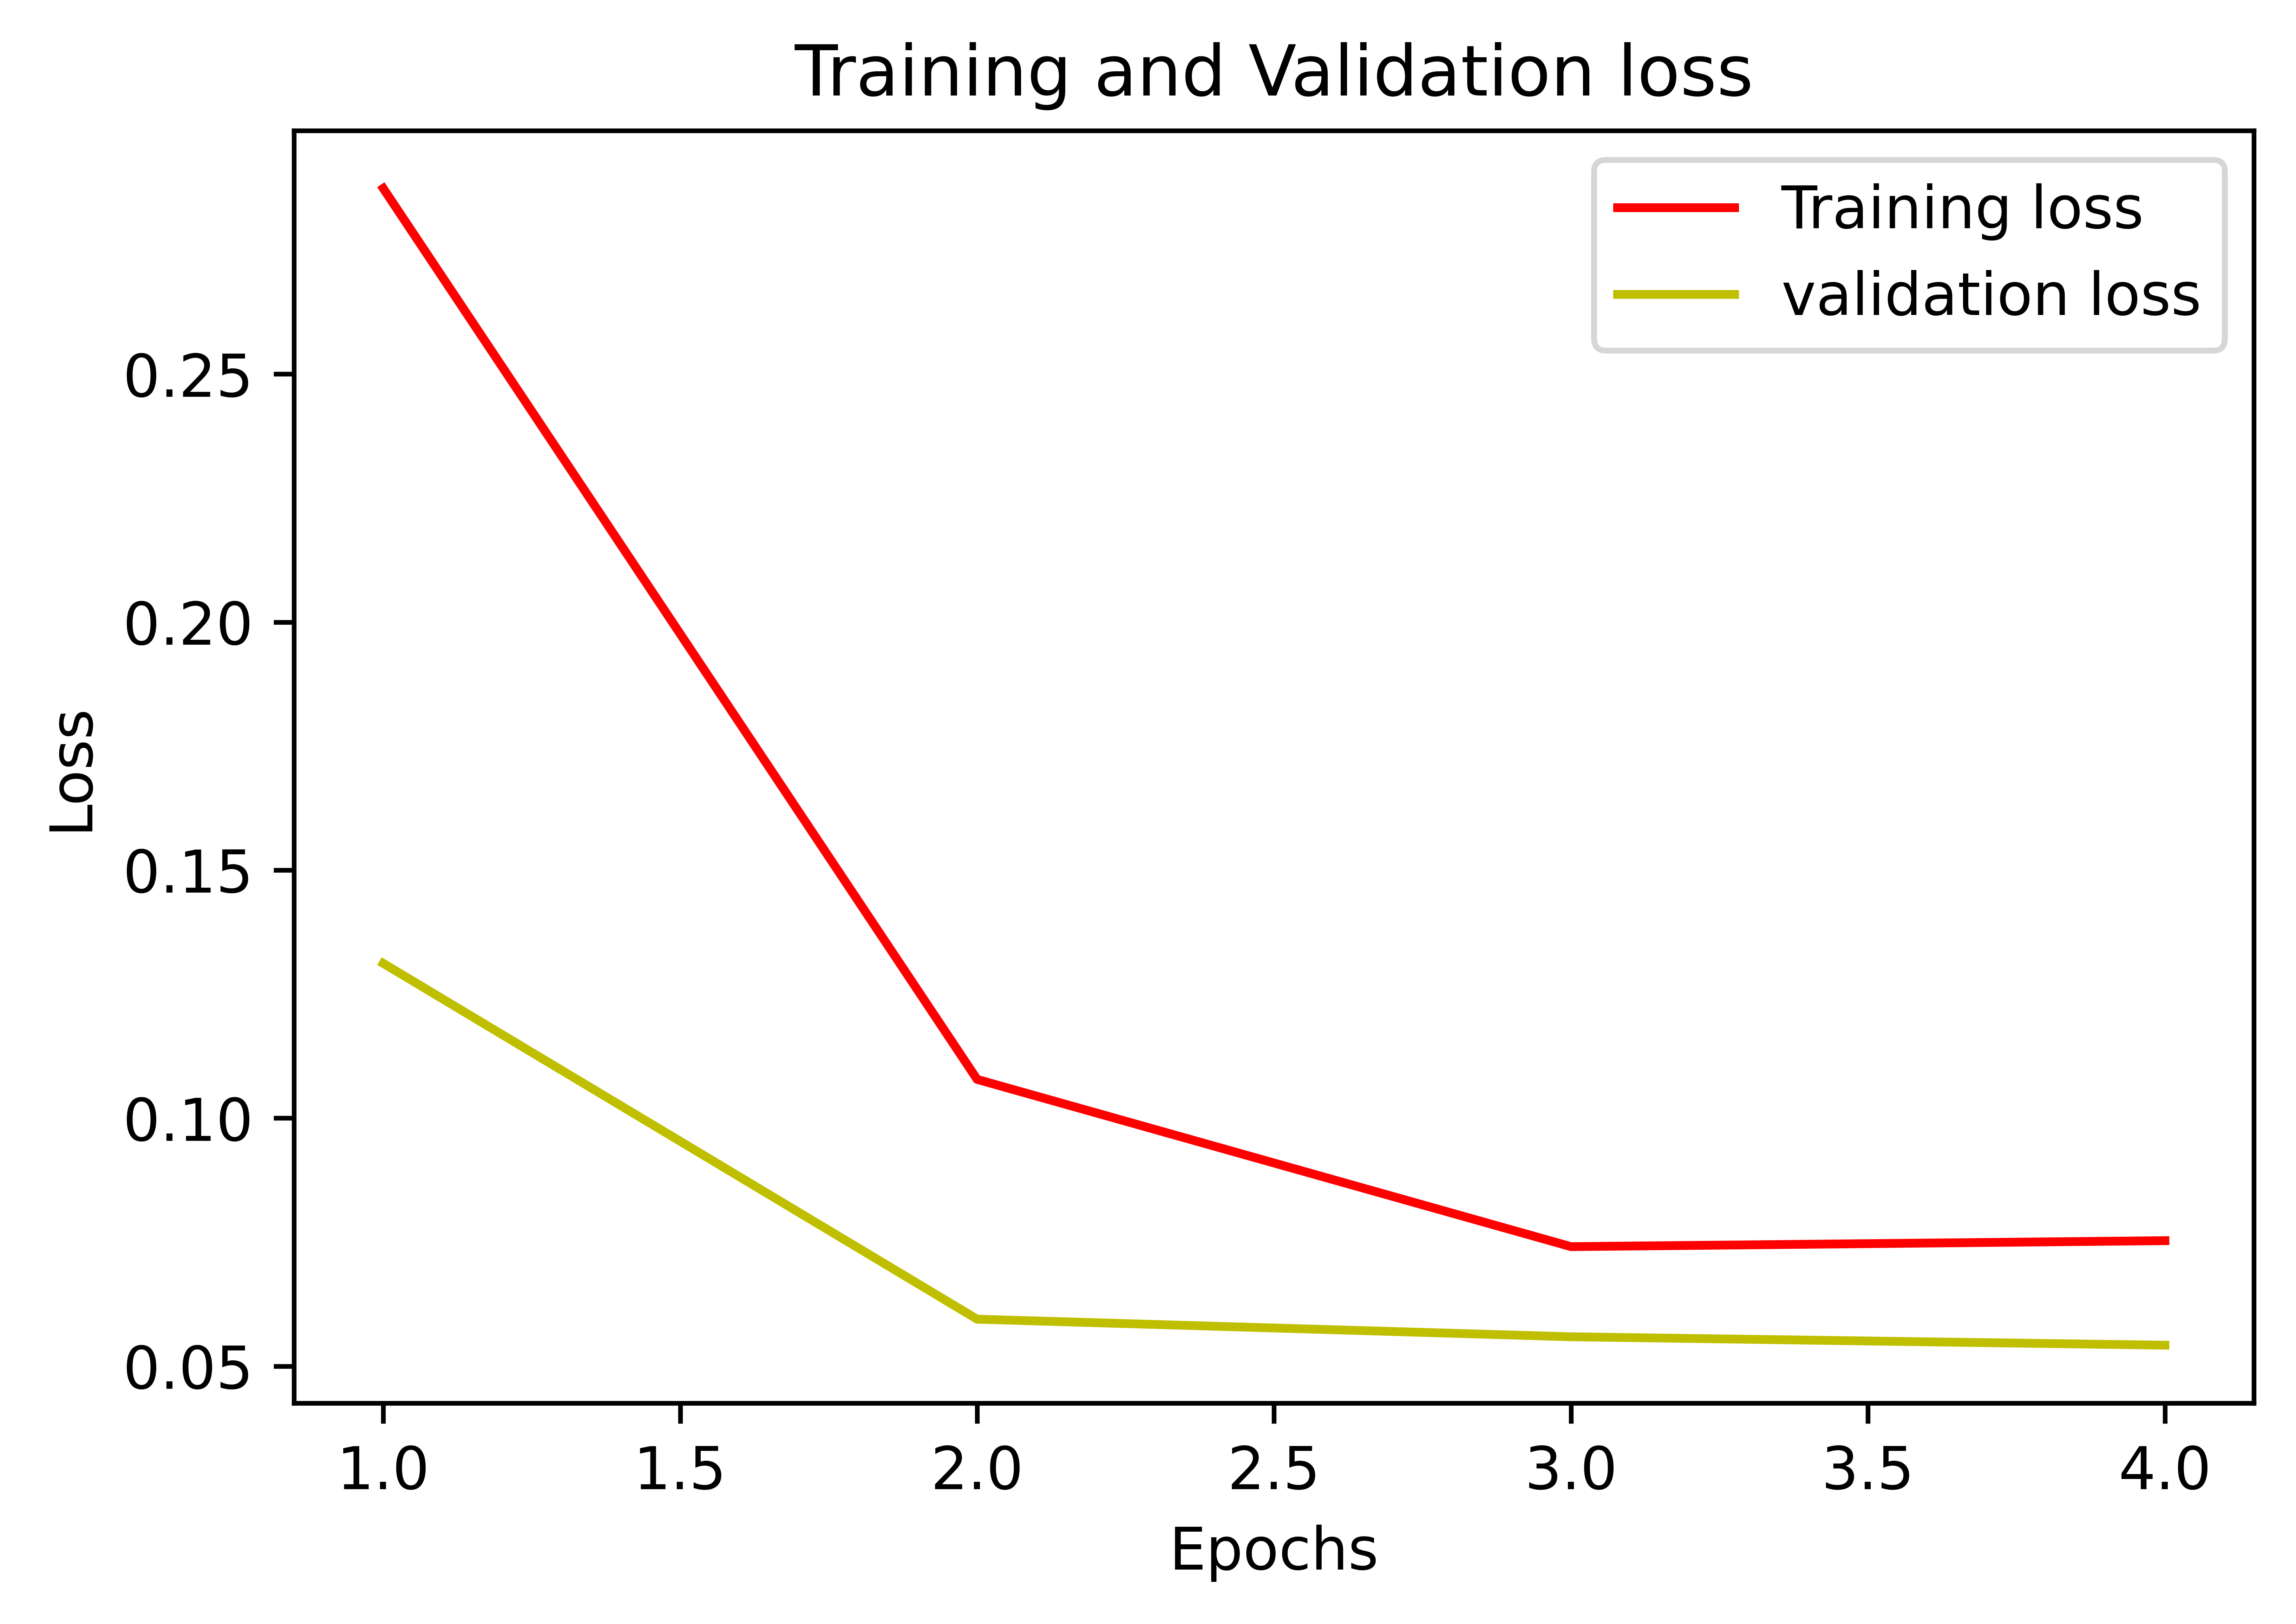

In [71]:
plt.figure(dpi=1200)
plt.plot(range(1,initial_epochs+1), history.history["loss"], 'r', label='Training loss')
plt.plot(range(1,initial_epochs+1), history.history["val_loss"], 'y', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png', dpi=1000)

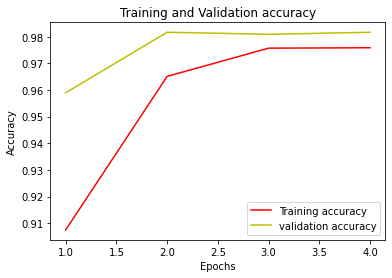

In [70]:
plt.plot(range(1,initial_epochs+1), history.history["accuracy"], 'r', label='Training accuracy')
plt.plot(range(1,initial_epochs+1), history.history["val_accuracy"], 'y', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accu.png', dpi=1000)

In [58]:
# save model in JSON format
model_json = model.to_json()
json_file = open("./model/model_weigts.json", "w")
json_file.write(model_json)
print("Model saved in JSON format!")
# save training weights in h5 file
model.save_weights("./model/model_weigts.h5")
print("\nModel weights saved!")

c:\Users\THINKPAD-E590\Projects\final_year_project\model\cropdisease-ml\.venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model saved in JSON format!

Model weights saved!


In [60]:
model.save("./model/model_trained.h5")

In [87]:
img1 = image.load_img('data\Corn_(maize)___Common_rust_\RS_Rust 1566.JPG', target_size=(256, 256))

In [4]:
img1 = image.load_img(r"C:\Users\THINKPAD-E590\Projects\final_year_project\model\cropdisease-ml\final_model\data\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG", target_size=(224, 224))
img = image.img_to_array(img1)

img_array_expanded_dims = np.expand_dims(img, axis=0)
img3 = preprocess_input(img_array_expanded_dims)
img3.shape

predictions = model.predict(img3)

NameError: name 'preprocess_input' is not defined

In [2]:
model = tf.keras.models.load_model('final_model/model/model.h5')

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 0.87862736


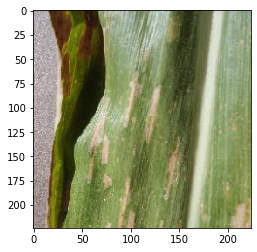

In [10]:
img1 = image.load_img(r"C:\Users\THINKPAD-E590\Projects\final_year_project\model\cropdisease-ml\final_model\data\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG", target_size=(224, 224))
img = image.img_to_array(img1)

plt.imshow(img1)

img_array_expanded_dims = np.expand_dims(img, axis=0)
img3 = preprocess_input(img_array_expanded_dims)
img3.shape

predictions = model.predict(img3)
print(class_names[predictions.argmax()], predictions[0][predictions.argmax()] )

(1, 225, 225, 3)
(1, 112, 112, 32)


<ipython-input-3-56d2e4adfb5b>:35: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()
<ipython-input-3-56d2e4adfb5b>:35: RuntimeWarning: divide by zero encountered in true_divide
  x /= x.std ()


(1, 112, 112, 32)
(1, 112, 112, 32)
(1, 112, 112, 32)
(1, 112, 112, 32)
(1, 112, 112, 32)
(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 112, 112, 64)
(1, 113, 113, 64)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 64)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 56, 56, 128)


<ipython-input-3-56d2e4adfb5b>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure( figsize=(scale * n_features, scale) )


(1, 56, 56, 128)
(1, 56, 56, 128)
(1, 57, 57, 128)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 128)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 28, 28, 256)
(1, 29, 29, 256)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 256)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 15, 15, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 512)
(1, 7, 7, 1024)
(1, 7, 7, 1024)
(1, 7, 7, 1024)
(1, 7,

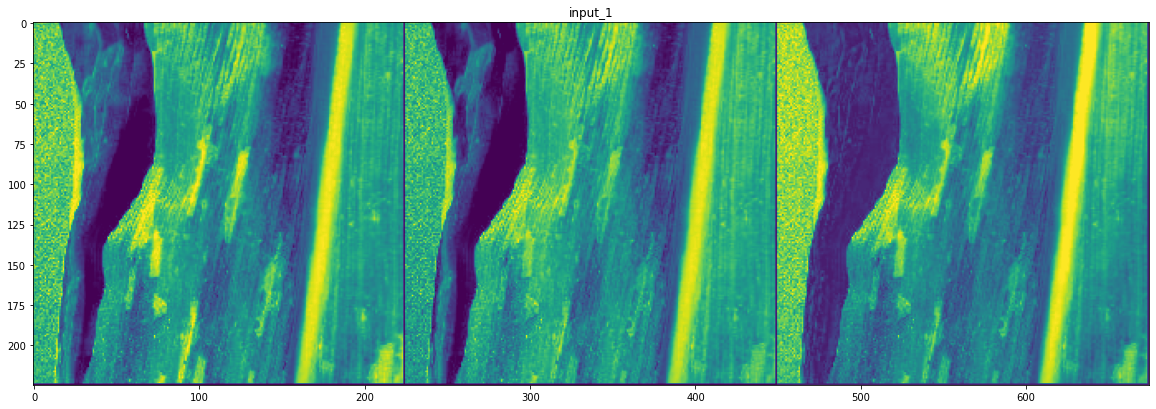

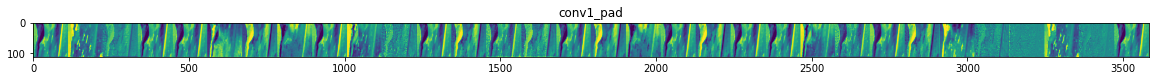

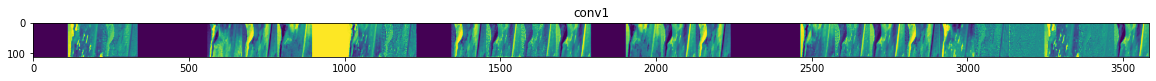

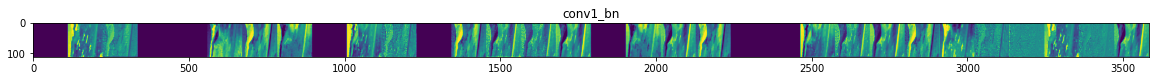

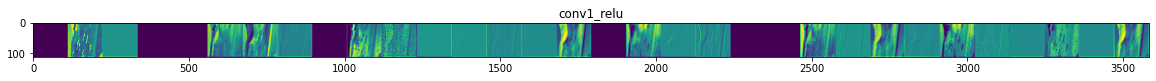

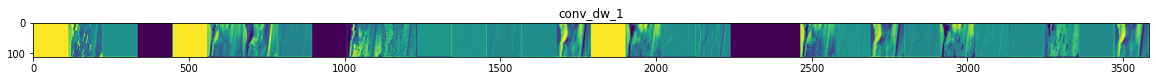

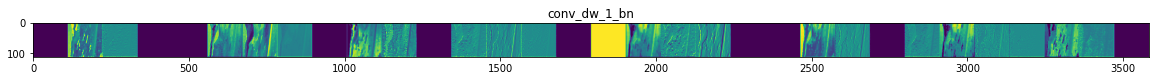

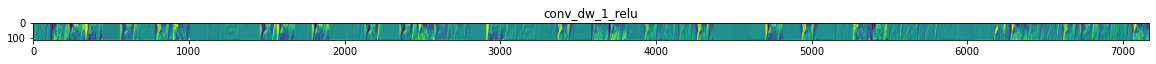

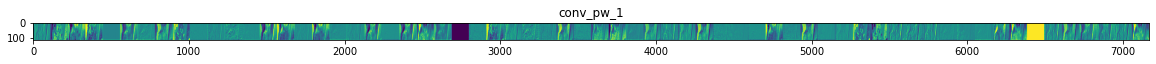

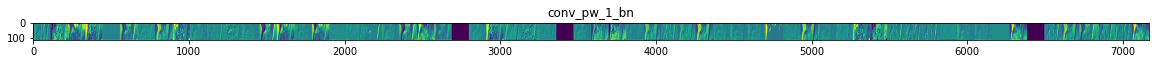

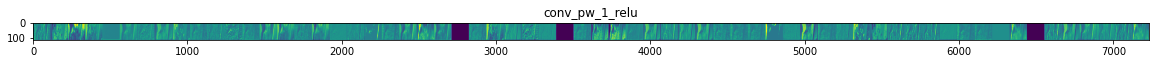

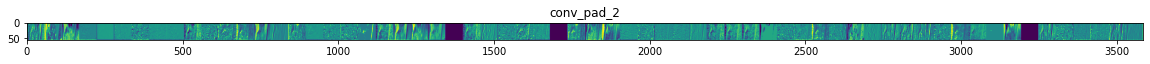

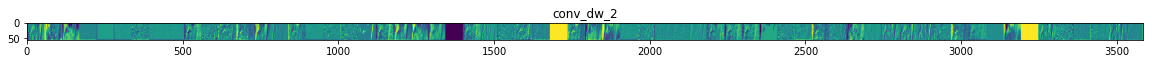

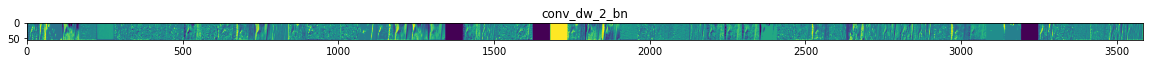

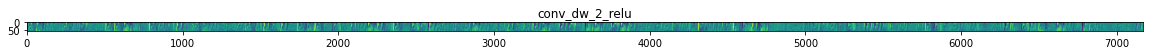

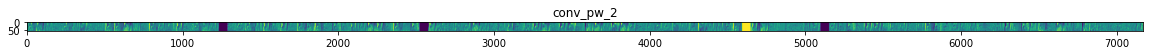

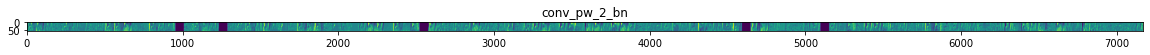

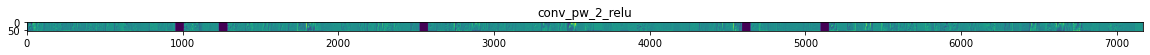

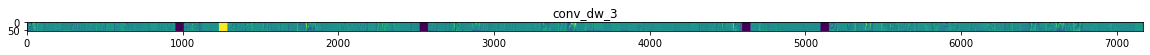

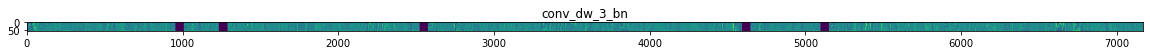

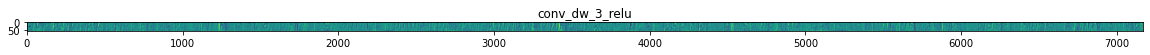

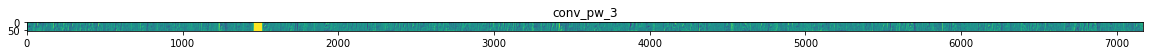

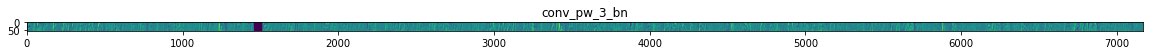

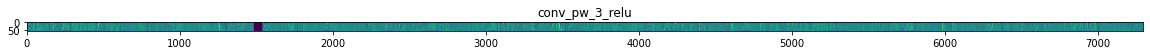

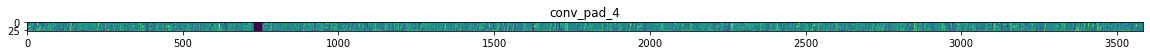

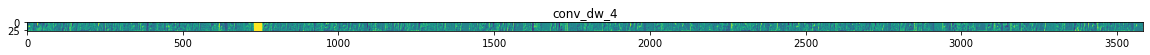

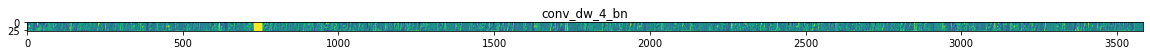

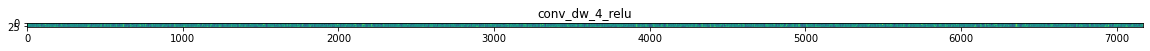

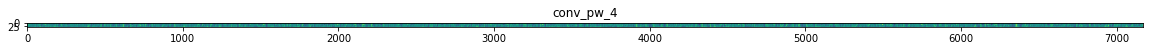

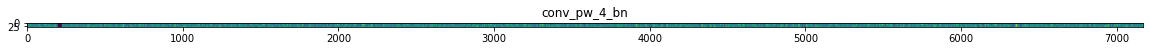

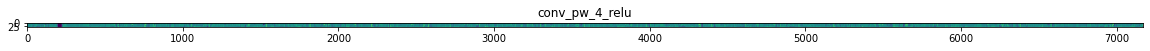

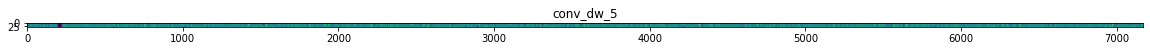

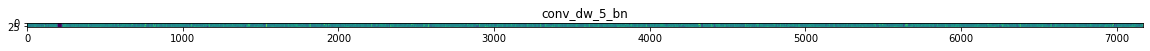

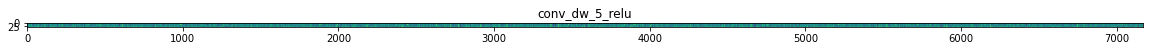

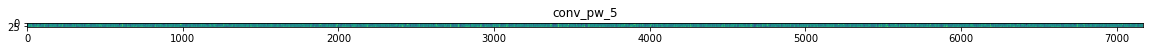

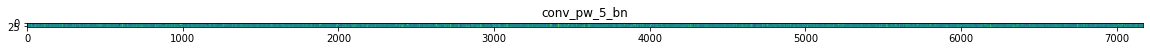

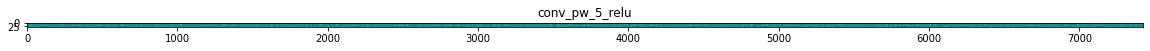

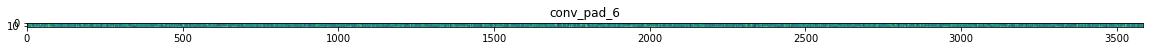

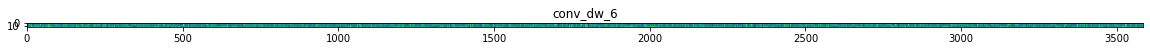

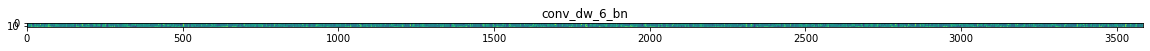

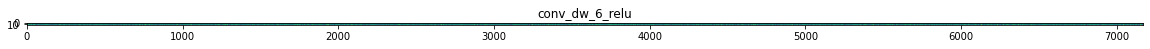

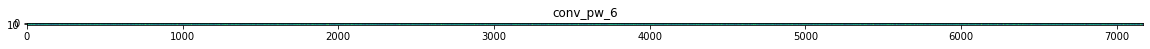

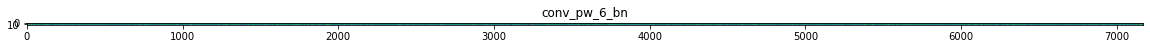

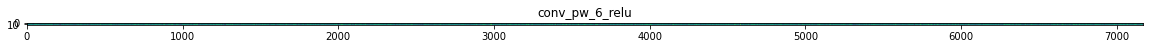

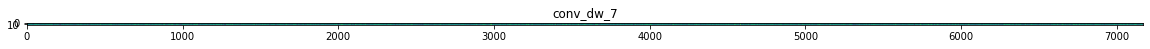

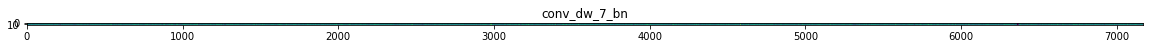

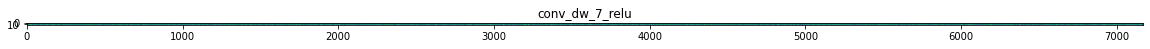

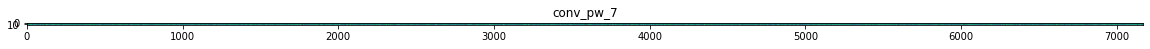

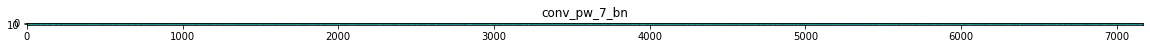

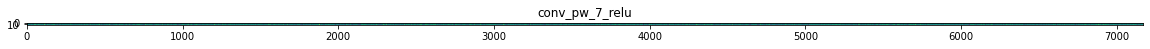

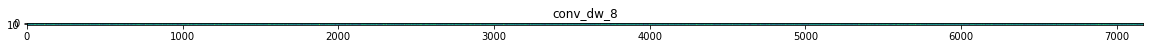

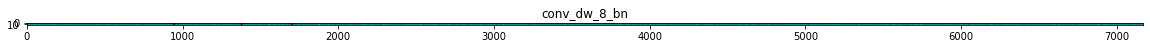

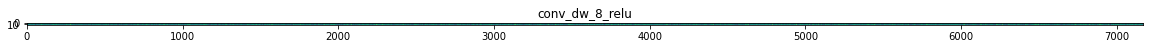

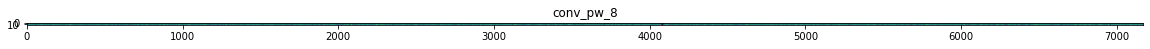

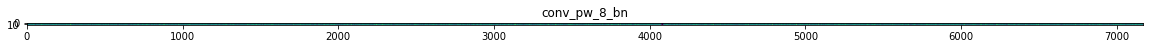

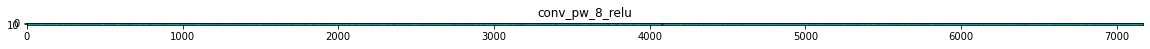

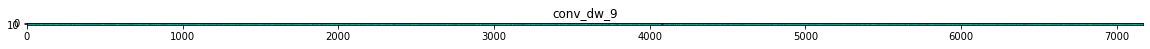

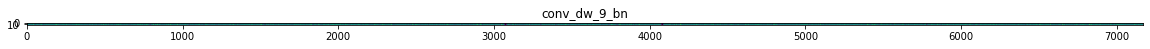

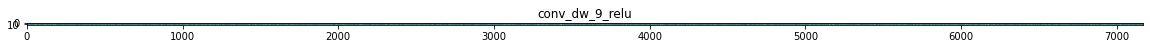

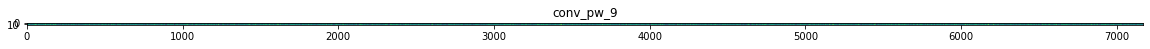

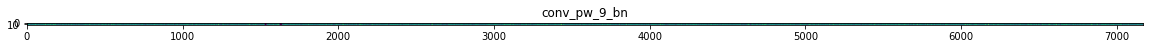

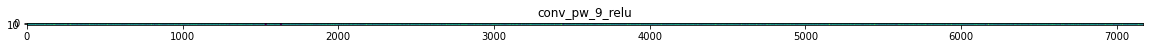

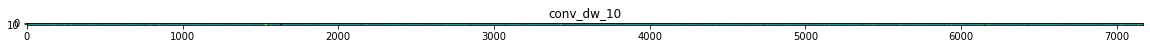

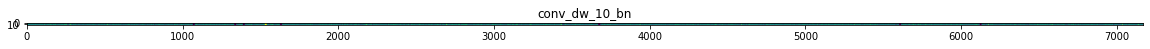

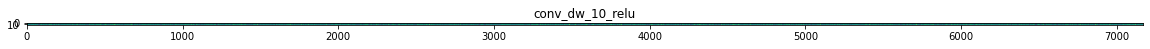

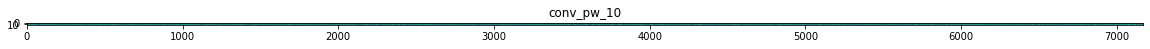

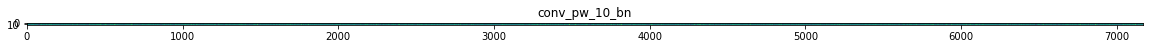

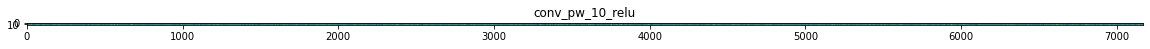

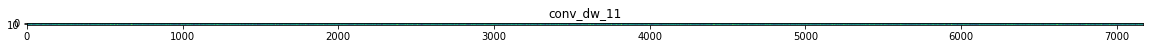

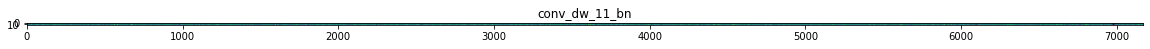

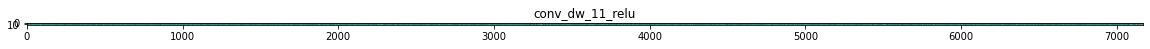

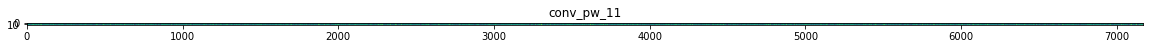

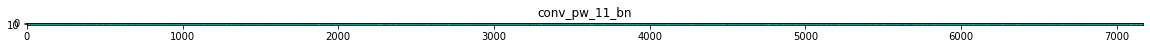

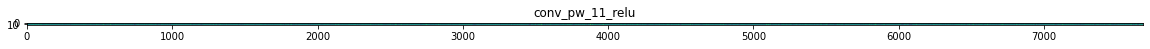

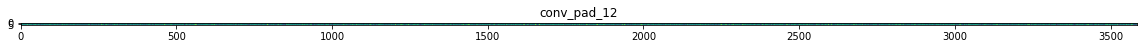

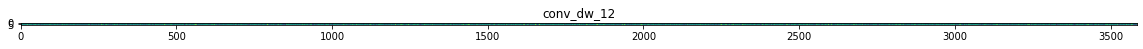

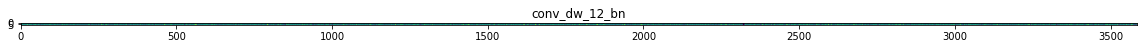

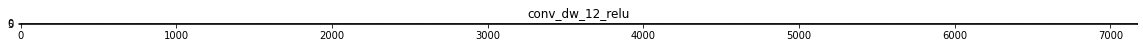

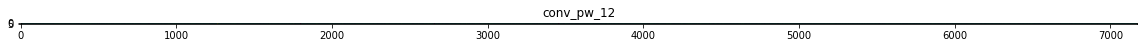

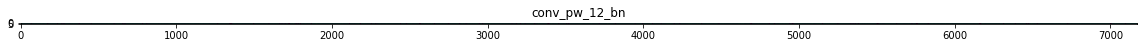

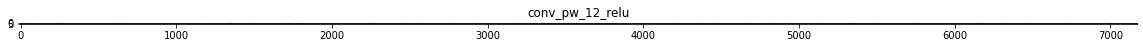

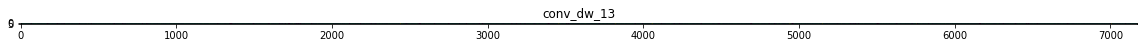

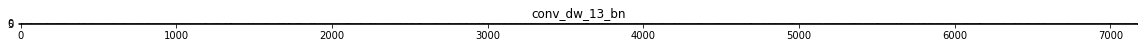

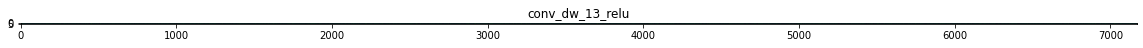

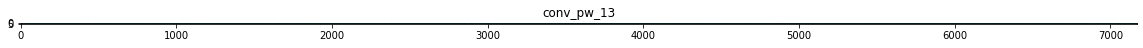

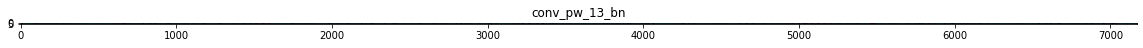

In [3]:
img = image.load_img(r"C:\Users\THINKPAD-E590\Projects\final_year_project\model\cropdisease-ml\final_model\data\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot\0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG", target_size=(224, 224))
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
# Convert ht image to Array of dimension (150,150,3)
x   = image.img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    plt.savefig('./md/{}.png'.format(layer_name), dpi=100)